# Analyse ROMY Events - ROMY vs ADR

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
# import multitaper

from obspy.clients.fdsn import Client


In [2]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill
from functions.compute_backazimuth import __compute_backazimuth
from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc
from functions.makeplot_comparison_ccf import __makeplot_comparison_ccf
from functions.get_event_info import __get_event_info
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform
from functions.compute_cwt import __compute_cwt
from functions.makeplot_waveforms import __makeplot_waveforms

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [40]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

## path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

## Event
config['tbeg'] = obs.UTCDateTime("2024-03-14 03:06")
config['tend'] = obs.UTCDateTime("2024-03-14 03:36")

config['seis'] = "DROMY"

config['event_name'] = "Montenegro"

config['filename'] = f"ROMY_{config['seis']}_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"

config['Client'] = Client("USGS")

## ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941



## Load Data

In [41]:
config, dist, baz, az = __get_event_info(config)

Event:	2024-03-14T03:06:47.754000Z | +42.954,  +18.688 | 5.4  mww | manual

	            resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000mirj&format=quakeml")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2024, 4, 17, 3, 56, 27, 710000))
	    preferred_origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us6000mirj/us/1713325770040/product.xml")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us6000mirj/us/1713325770040/product.xml#magnitude")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements
Distance  817.8940052746909 km Azimuth  317.60939995319507 Backazimuth  132.30780514463933


In [42]:
st0 = obs.read(config['path_to_data']+config['filename'])

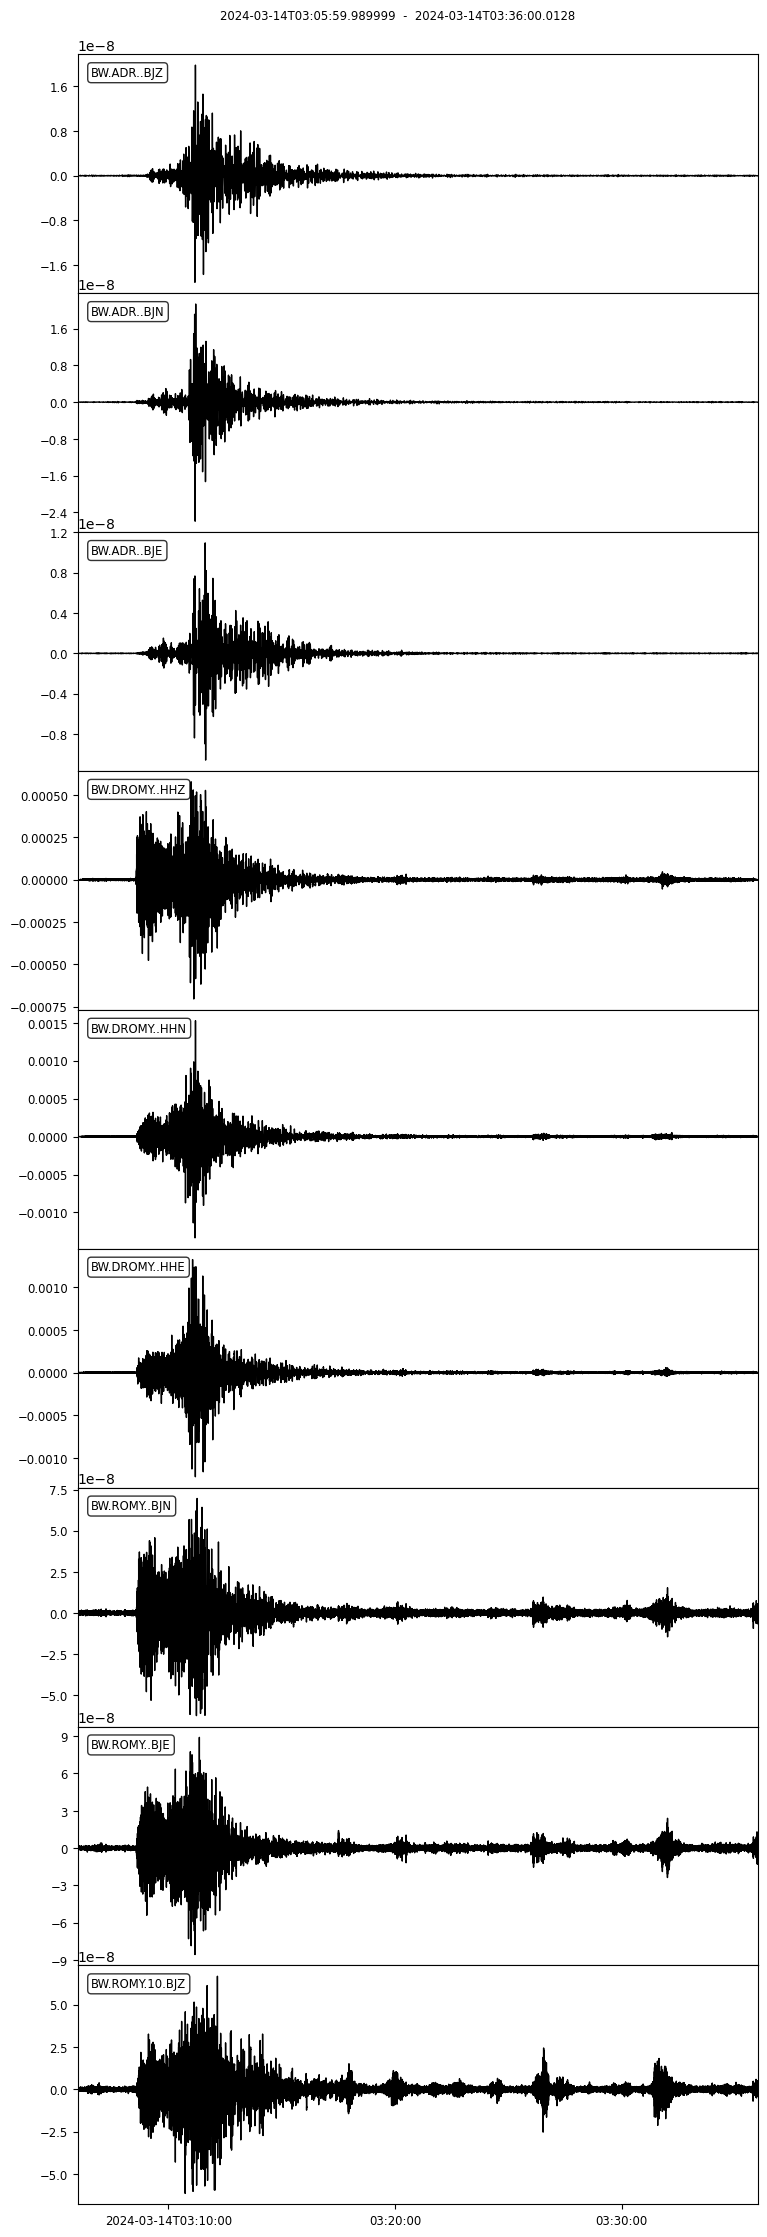

In [43]:
st0.plot(equal_scale=False);

In [45]:
dt1, dt2 = 120, 1100
st0 = st0.trim(config['tbeg']+dt1, config['tend']-dt2)


## Spectra

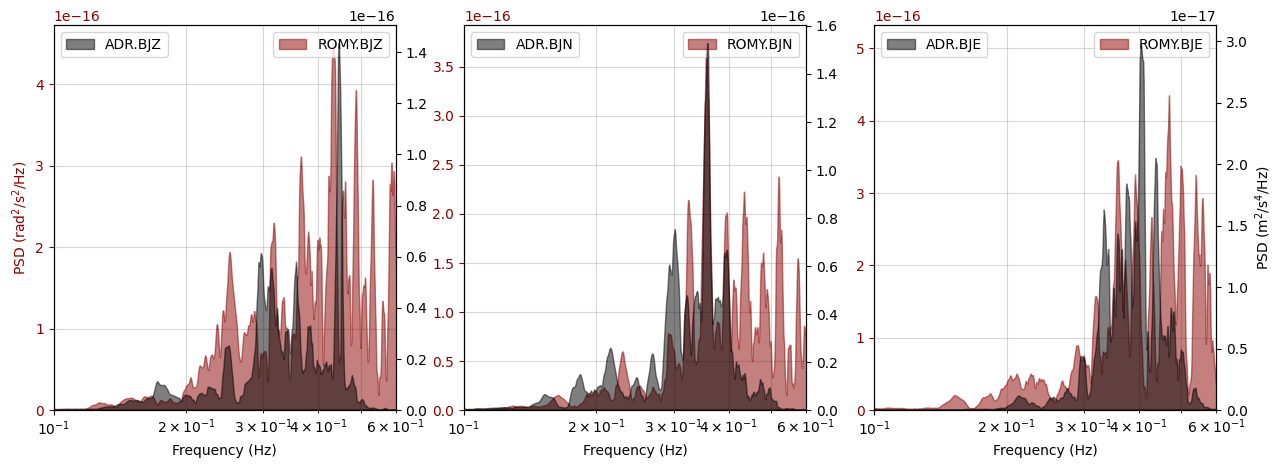

In [53]:

from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill

adr0 = st0.select(station="ADR", channel="*J*").copy()
acc0 = st0.select(station="FUR", channel="*H*").copy()
rot0 = st0.select(station="ROMY", channel="*J*").copy()

rot0 = rot0.detrend("simple")
acc0 = acc0.detrend("simple")
adr0 = adr0.detrend("simple")

fig = __makeplot_spectra_comparison_fill(rot0, adr0, fmin=0.1, fmax=0.6, ylog=False, xlog=True, fill=True)

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_spectra_all.png", format="png", dpi=150, bbox_inches='tight');


### Continueous Wavelet Transform

In [80]:
for component in ["E", "N", "Z"]:

    ttt = rot0[0].times()
    arr = rot0.select(channel=f"*{component}")[0].data
    dt = rot0[0].stats.delta # seconds

    # out = __compute_cwt(ttt, arr, dt, tscale="sec",
    #                     datalabel=f"ROMY-{component}",
    #                     period=False,
    #                     ymax=10,
    #                     plot=True,
    #                    )

    # out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_cwt_{component}.png",
    #                    format="png", dpi=150, bbox_inches='tight');


### Cross Wavelet Transform

In [ ]:

out = __compute_cross_wavelet_transform(
                                        rot0[0].times(),
                                        rot0.select(channel=f"*{component}")[0].data,
                                        acc0.select(channel=f"*{component}")[0].data,
                                        rot0[0].stats.delta,
                                        xwt_threshold=0.,
                                        ymax=10,
                                        normalize=False,
                                        ylog=True,
                                        clog=True,
                                        plot=True,
)

# out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_xwt_{component}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [ ]:
from scipy.signal import hilbert
from obspy.signal.tf_misfit import plot_tf_misfits

for component in ["Z", "N", "E"]:

    st1 = st0.copy()

    st1 = st1.detrend("demean").taper(0.01, type="cosine").filter("bandpass", freqmin=0.01, freqmax=10, corners=4, zerophase=True)

    s1 = st1.select(station="ROMY", channel=f"*{component}")[0].data
    s2 = st1.select(station="FUR", channel=f"*{component}")[0].data

    plot_tf_misfits(s1, s2, dt=st1[0].stats.delta, fmin=0.01, fmax=20, show=True, norm="global")


## Filter

In [82]:

fmin, fmax = 0.1, 0.5

rot1 = st0.select(station="ROMY", channel="*J*").copy()
acc1 = st0.select(station="FUR", channel="*H*").copy()
adr1 = st0.select(station="ADR", channel="*J*").copy()

rot1 = rot1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
acc1 = acc1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
adr1 = adr1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);


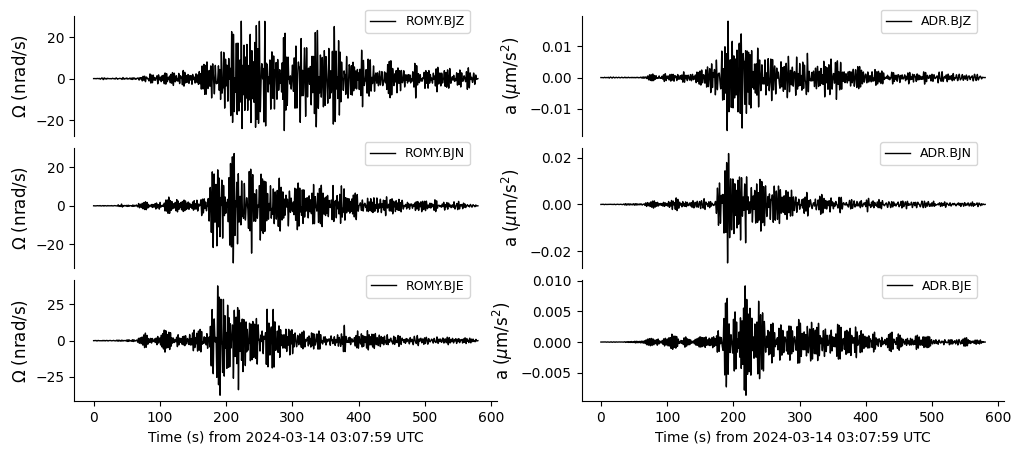

In [83]:
fig = __makeplot_waveforms(adr1, rot1);

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms.png", format="png", dpi=200, bbox_inches='tight')


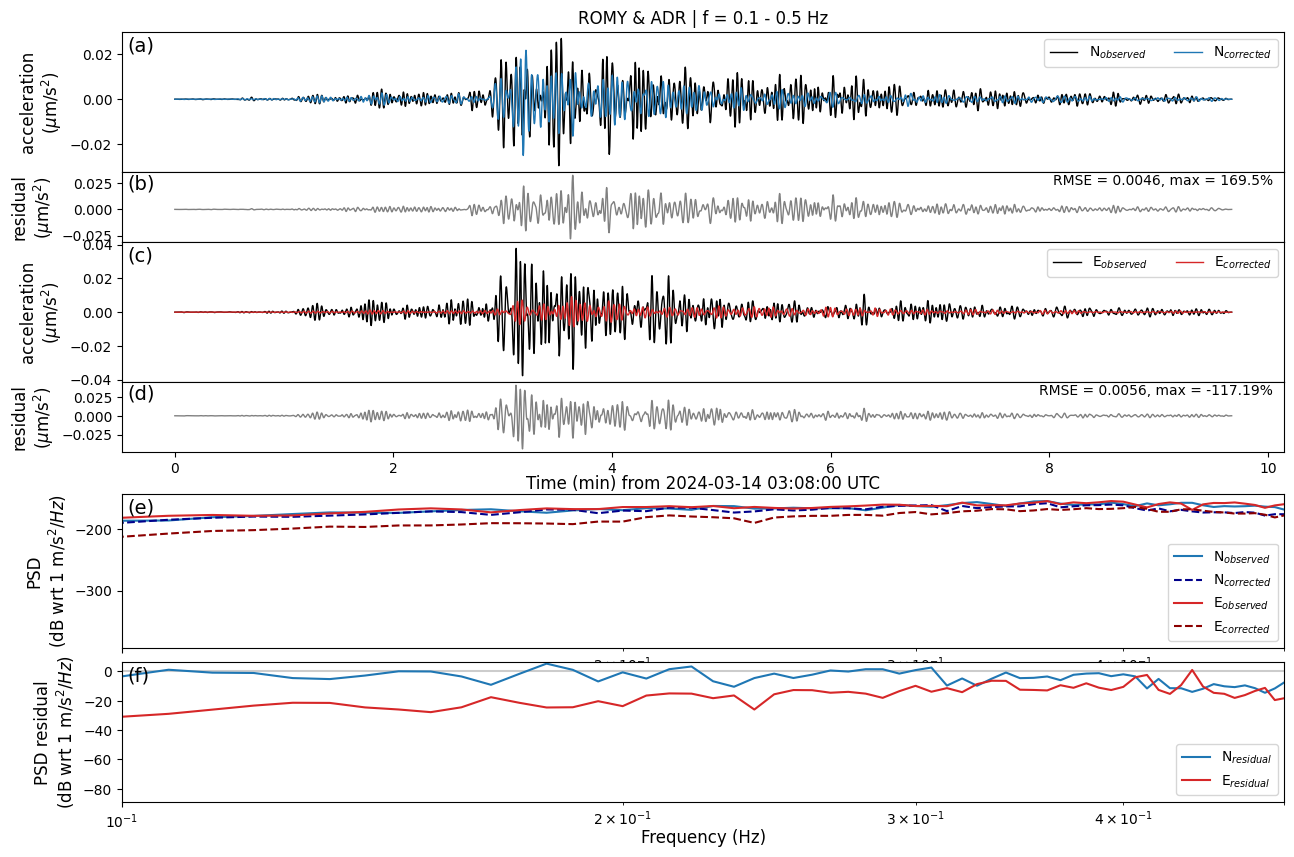

In [87]:
def __makeplot(st1, st2):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd

    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*100, 2)
        return pmax

    def __to_dB(psd):
        return 10*np.log10(psd)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)


    tscale, tunit = 1/60, "min"

    times = st1.select(channel="*N")[0].times()

    Ncol, Nrow = 1, 11

    font = 12

    lw = 1

    scale, unit = 1e6, f"$\mu$m/s$^2$"

    fig = plt.figure(figsize=(15, 10))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=10000)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])
    ax5 = fig.add_subplot(gs2[6:9, :])
    ax6 = fig.add_subplot(gs[9:11, :])

    accN = st1.select(channel="*N")[0].data*scale
    accE = st1.select(channel="*E")[0].data*scale

    accN_c = st2.select(channel="*N")[0].data*scale
    accE_c = st2.select(channel="*E")[0].data*scale

    # psd before and after
    dt = st1.select(channel="*N")[0].stats.delta
    # fN1, psdN1 = __multitaper_psd(accN/scale, dt, n_win=5, time_bandwidth=3.0)
    # fN2, psdN2 = __multitaper_psd(accN_c/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE1, psdE1 = __multitaper_psd(accE/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE2, psdE2 = __multitaper_psd(accE_c/scale, dt, n_win=5, time_bandwidth=3.0)

    fN1, psdN1 = __welch_psd(accN/scale, dt, twin_sec=150)
    fN2, psdN2 = __welch_psd(accN_c/scale, dt, twin_sec=150)
    fE1, psdE1 = __welch_psd(accE/scale, dt, twin_sec=150)
    fE2, psdE2 = __welch_psd(accE_c/scale, dt, twin_sec=150)

    ax1.plot(times*tscale, accN, color="black", label="N$_{observed}$", lw=lw)
    ax1.plot(times*tscale, accN_c, color="tab:blue", label="N$_{corrected}$", lw=lw)

    ax2.plot(times*tscale, (accN-accN_c), color="grey", label=f"RMSE = {__rmse(accN, accN_c)}, max = {__get_residual_percent(accN, accN_c)}%", lw=lw)


    ax3.plot(times*tscale, accE, color="black", label="E$_{observed}$", lw=lw)
    ax3.plot(times*tscale, accE_c, color="tab:red", label="E$_{corrected}$", lw=lw)

    ax4.plot(times*tscale, (accE-accE_c), color="grey", label=f"RMSE = {__rmse(accE, accE_c)}, max = {__get_residual_percent(accE, accE_c)}%", lw=lw)


    ax5.plot(fN1, __to_dB(psdN1), label="N$_{observed}$", color="tab:blue")
    ax5.plot(fN2, __to_dB(psdN2), label="N$_{corrected}$", color="darkblue", ls="--")
    # ax5.fill_between(fN2, __to_dB(psdN1), __to_dB(psdN2), color="tab:blue", alpha=0.3)

    ax5.plot(fE1, __to_dB(psdE1), label="E$_{observed}$", color="tab:red")
    ax5.plot(fE2, __to_dB(psdE2), label="E$_{corrected}$", color="darkred", ls="--")
    # ax5.fill_between(fN2, __to_dB(psdE1), __to_dB(psdE2), color="tab:red", alpha=0.3)

    # ax5.fill_between(fN1, 0, __to_dB(psdN2) - __to_dB(psdN1), label="N diff", color="tab:blue", alpha=0.4)
    # ax5.fill_between(fE1, 0, __to_dB(psdE2) - __to_dB(psdE1), label="E diff", color="tab:red", alpha=0.4)


    # ax5.set_ylim(-160, -135)
    # ax5.set_ylim(-170, -140)
    ax5.set_xscale("log")
    ax5.set_xlim(fmin, fmax)
    ax5.legend(loc=4)
    ax5.set_xticklabels([])

    diffN = __to_dB(psdN2) - __to_dB(psdN1)
    diffE = __to_dB(psdE2) - __to_dB(psdE1)
    ax6.plot(fN1, diffN, label="N$_{residual}$", color="tab:blue")
    ax6.plot(fE1, diffE, label="E$_{residual}$", color="tab:red")
    # ax6.fill_between(fN1, 0, diffN, label="N$_{residual}$", color="tab:blue", alpha=0.4)
    # ax6.fill_between(fE1, 0, diffE, label="E$_{residual}$", color="tab:red", alpha=0.4)

    ax6.plot([fmin, fmax], [0, 0], alpha=0.2, color="k", zorder=0)

    min_lim, max_lim = __get_lim([diffN, diffE])
    ax6.set_ylim(min_lim*1.2, max_lim*1.2)

    ax6.set_xlim(fmin, fmax)
    ax6.set_xscale("log")
    ax6.legend(loc=4)
    ax6.set_ylim()


    for ax in [ax1, ax3]:
        ax.legend(loc=1, ncol=2)

    ax1.set_ylabel(f"acceleration\n({unit})", fontsize=font)
    ax3.set_ylabel(f"acceleration\n({unit})", fontsize=font)
    ax5.set_ylabel(f"PSD\n(dB wrt 1 m/s$^2/Hz$)", fontsize=font)
    ax6.set_ylabel(f"PSD residual\n(dB wrt 1 m/s$^2/Hz$)", fontsize=font)

    ax2.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax4.set_ylabel(f"residual\n({unit})", fontsize=font)

    for ax in [ax1, ax2, ax3]:
        ax.get_xaxis().set_visible(False)

#     ax3.set_ylabel(f"East Tilt ({tilt_unit})", fontsize=font)
#     ax4.set_ylabel(f"Residual \n ({tilt_unit})", fontsize=font)
    ax4.set_xlabel(f"Time ({tunit}) from {st1[0].stats.starttime.date} {str(st1[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font, labelpad=-1)
    ax6.set_xlabel(f"Frequency (Hz)", fontsize=font, labelpad=-1)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2)

    txt = f"RMSE = {__rmse(accN, accN_c)}, max = {__get_residual_percent(accN, accN_c)}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    txt = f"RMSE = {__rmse(accE, accE_c)}, max = {__get_residual_percent(accE, accE_c)}%"
    ax4.text(.99, .97, txt, ha='right', va='top', transform=ax4.transAxes, fontsize=font-2)

    ax1.set_title(f"{st1[0].stats.station} & {st2[0].stats.station} | f = {fmin} - {fmax} Hz")

    plt.plot();
    return fig

fig = __makeplot(rot1, adr1)

# fig.savefig(config['path_to_figs']+f"RomyTiltCorrection_{config['event_name']}_{config['tbeg'].date}_{til1[0].stats.station}_{acc1[0].stats.station}.png", format="png", dpi=150, bbox_inches='tight')


## Waveform Comparison

In [85]:
for tr in acc1:
    if "Z" in tr.stats.channel:
        tr.data *= -1

# fig = __makeplot_waveform_comparison_cc(rot1, acc1, baz, fmin, fmax, dist, twin_sec=15, twin_overlap=0.5)

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms_cc.png", format="png", dpi=150, bbox_inches='tight');


In [ ]:
fig = __makeplot_comparison_ccf(rot1, acc1, baz, dist, twin_sec=10, twin_overlap=0.5, fmin=fmin, fmax=fmax)

## Backazimuth

In [ ]:
from functions.compute_backazimuth import __compute_backazimuth
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [ ]:
config['station_longitude'] = config['ROMY_lon']
config['station_latitude']  = config['ROMY_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 20

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 75

## specify steps for degrees of baz
config['step'] = 1


baz, az, dist = __get_theoretical_backazimuth(config['ROMY_lat'], config['ROMY_lon'], event_obj=config['event'], fdsn_client='USGS')


In [ ]:
out1 = __compute_backazimuth(
                            acc1,
                            rot1,
                            config,
                            wave_type='love',
                            event=config['event'],
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

out1['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_love_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out2 = __compute_backazimuth(
                            acc1,
                            rot1,
                            config,
                            wave_type='rayleigh',
                            event=config['event'],
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

out2['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_rayleigh_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out3 = __compute_backazimuth_tangent(
                                    rot1,
                                    acc1,
                                    win_time_s=config['win_length_sec'],
                                    overlap=config['overlap']/100,
                                    baz_theo=baz,
                                    cc_thres=0.1,
                                    plot=True,
                                    invert_acc_z=False,
                                    )

out3['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_tangent_{rot1[0].stats.station}{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


In [ ]:
out4 = __compare_backazimuth_codes(rot1, acc1, config['event'], fmin, fmax,
                                   config['win_length_sec'], config['overlap'],
                                   cc_thres=0.2, invert_acc_z=False, invert_rot_z=False, plot=True,
                                  );

out4['fig3'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_comparison_{rot1[0].stats.location}_{fmin}_{fmax}_all.png", dpi=150, bbox_inches='tight', pad_inches=0.05);
